# <font color='blue'> News Sentiment Analysis

In [1]:
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import keras_tuner as kt
from keras.models import Sequential
from keras.layers import Dense,Dropout,BatchNormalization
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sns

In [2]:
df=pd.read_csv(r"G:\ML projects\news.csv")

In [3]:
df.head()

,Headline,Label
0,Four ways Bob Corker skewered Donald Trump,1
1,Linklater's war veteran comedy speaks to moder...,1
2,Trump’s Fight With Corker Jeopardizes His Legi...,1
3,Egypt's Cheiron wins tie-up with Pemex for Mex...,1
4,Jason Aldean opens 'SNL' with Vegas tribute,1


In [4]:
df.shape

(4009, 2)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4009 entries, 0 to 4008
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Headline  4009 non-null   object
 1   Label     4009 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 62.8+ KB


## <font color='red'> Preprocessing

In [6]:
prep=[]
for i in df['Headline']:
    word=re.sub('[^a-z ]',"",i)
    word=i.lower()
    prep.append(word)

In [7]:
df['cleaned_headlines']=prep

In [8]:
df.head()

,Headline,Label,cleaned_headlines
0,Four ways Bob Corker skewered Donald Trump,1,four ways bob corker skewered donald trump
1,Linklater's war veteran comedy speaks to moder...,1,linklater's war veteran comedy speaks to moder...
2,Trump’s Fight With Corker Jeopardizes His Legi...,1,trump’s fight with corker jeopardizes his legi...
3,Egypt's Cheiron wins tie-up with Pemex for Mex...,1,egypt's cheiron wins tie-up with pemex for mex...
4,Jason Aldean opens 'SNL' with Vegas tribute,1,jason aldean opens 'snl' with vegas tribute


In [9]:
tfv=TfidfVectorizer()
x=tfv.fit_transform(df['cleaned_headlines']).toarray()

In [10]:
y=df["Label"]

In [11]:
y.value_counts()

0    2137
1    1872
Name: Label, dtype: int64

In [12]:
xtrain,xtest,ytrain,ytest=train_test_split(x,y,train_size=0.75)

### Tunning model

In [13]:
def build_model(hp):
    nn= Sequential()
    
    #units
    hp1=hp.Int('unit1',min_value=16,max_value=512,step=32)
    hp2=hp.Int('unit2',min_value=16,max_value=512,step=32)
    hp3=hp.Int('unit3',min_value=16,max_value=512,step=32)
    
    #dropout
    dp1=hp.Float('drop1',min_value=0.2,max_value=0.5,step=0.1)
    dp2=hp.Float('drop2',min_value=0.2,max_value=0.5,step=0.1)
    dp3=hp.Float('drop3',min_value=0.2,max_value=0.5,step=0.1)
    
    #1st hidden layer
    nn.add(Dense(units=hp1,input_dim=xtrain.shape[1],activation='relu'))
    nn.add(Dropout(dp1))
    
    #2nd Hidden layer
    nn.add(Dense(units=hp2,activation='relu'))
    nn.add(Dropout(dp2))
    
    #3rd hidden layer
    nn.add(Dense(units=hp3,activation='relu'))
    nn.add(Dropout(dp3))
    
    #o/p layer
    nn.add(Dense(1,activation='sigmoid'))
    
    nn.compile(loss='binary_crossentropy',optimizer='adam',metrics='accuracy')
    return nn

In [14]:
tuner=kt.Hyperband(build_model,objective='val_loss',max_epochs=10,directory='keras_tuner_dir',
                     project_name='keras_tuner_proj')

In [15]:
tuner.search(xtrain,ytrain,validation_split=0.2,epochs=30)

Trial 30 Complete [00h 00m 41s]
val_loss: 0.42010053992271423

Best val_loss So Far: 0.3996957242488861
Total elapsed time: 00h 05m 31s
INFO:tensorflow:Oracle triggered exit


In [16]:
hparams = tuner.get_best_hyperparameters()[0]
hparams

In [35]:
print('{} unit for layer 1'.format(hparams.get('unit1')) )
print('{} unit for layer 2'.format(hparams.get('unit2')))
print('{} unit for layer 3'.format(hparams.get('unit3')))
print('{} dropout for layer 1'.format(hparams.get('drop1')))
print('{} dropout for layer 2'.format(hparams.get('drop2')))
print('{} dropout for layer 3'.format(hparams.get('drop3')))

208 unit for layer 1
144 unit for layer 2
304 unit for layer 3
0.4 dropout for layer 1
0.2 dropout for layer 2
0.4 dropout for layer 3


### Building model

In [20]:
nn=Sequential()

#1st hidden layer
nn.add(Dense(208,activation='relu',input_dim=xtrain.shape[1]))
nn.add(Dropout(0.4))
nn.add(BatchNormalization())

#2nd hidden layer
nn.add(Dense(144,activation='relu'))
nn.add(Dropout(0.2))
nn.add(BatchNormalization())

nn.add(Dense(304,activation='relu'))
nn.add(Dropout(0.4))
nn.add(BatchNormalization())


#output
nn.add(Dense(1,activation='sigmoid'))

In [21]:
early_stop=EarlyStopping(monitor='val_loss',patience=10)

In [22]:
nn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 208)               1489696   
                                                                 
 dropout_3 (Dropout)         (None, 208)               0         
                                                                 
 batch_normalization (BatchN  (None, 208)              832       
 ormalization)                                                   
                                                                 
 dense_5 (Dense)             (None, 144)               30096     
                                                                 
 dropout_4 (Dropout)         (None, 144)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 144)              576       
 hNormalization)                                      

In [23]:
nn.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [24]:
hist = nn.fit(xtrain, ytrain,
              validation_split=0.2,
              batch_size=8,
              epochs=100,
              callbacks=[early_stop])

Epoch 1/100
301/301 [==============================] - 8s 22ms/step - loss: 0.7642 - accuracy: 0.5874 - val_loss: 0.8191 - val_accuracy: 0.4668
Epoch 2/100
301/301 [==============================] - 6s 21ms/step - loss: 0.5212 - accuracy: 0.7550 - val_loss: 0.5955 - val_accuracy: 0.7276
Epoch 3/100
301/301 [==============================] - 6s 21ms/step - loss: 0.3858 - accuracy: 0.8307 - val_loss: 0.5418 - val_accuracy: 0.8023
Epoch 4/100
301/301 [==============================] - 6s 21ms/step - loss: 0.2732 - accuracy: 0.8906 - val_loss: 0.5078 - val_accuracy: 0.8106
Epoch 5/100
301/301 [==============================] - 6s 21ms/step - loss: 0.1892 - accuracy: 0.9255 - val_loss: 0.5022 - val_accuracy: 0.8123
Epoch 6/100
301/301 [==============================] - 6s 21ms/step - loss: 0.1893 - accuracy: 0.9230 - val_loss: 0.5537 - val_accuracy: 0.8156
Epoch 7/100
301/301 [==============================] - 6s 21ms/step - loss: 0.1675 - accuracy: 0.9359 - val_loss: 0.5718 - val_accuracy:

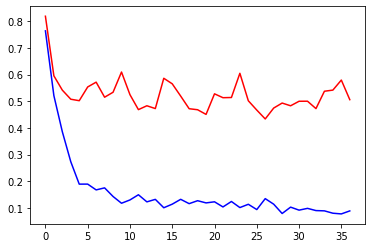

In [25]:
plt.plot(hist.history['loss'],c='blue')
plt.plot(hist.history['val_loss'],c='red')

In [26]:
nn.evaluate(xtrain,ytrain)

94/94 [==============================] - 0s 2ms/step - loss: 0.1058 - accuracy: 0.9601


[0.10580886155366898, 0.9600798487663269]

In [27]:
nn.evaluate(xtest, ytest)

32/32 [==============================] - 0s 2ms/step - loss: 0.4225 - accuracy: 0.8255


[0.4225236475467682, 0.8255234360694885]

### Sklearn Metrics

In [28]:
prob=nn.predict(xtest)

32/32 [==============================] - 0s 2ms/step


In [29]:
pred=[]
for i in prob:
    if i >= 0.5:
        pred.append(1)
    else: 
        pred.append(0)

In [30]:
print(classification_report(ytest,pred))

              precision    recall  f1-score   support

           0       0.95      0.71      0.81       530
           1       0.74      0.96      0.84       473

    accuracy                           0.83      1003
   macro avg       0.85      0.83      0.82      1003
weighted avg       0.85      0.83      0.82      1003



<AxesSubplot:>

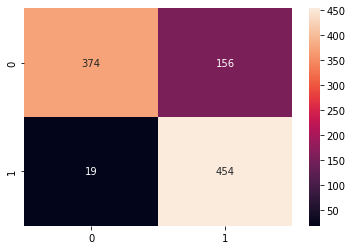

In [31]:
sns.heatmap(confusion_matrix(ytest,pred),annot=True,fmt='d')

# conclusion:
We have sucessfully built the model on news data using neural network with 83% accuracy